Saved per-image luminance to:
  C:\Users\micha\Desktop\AGNG\Images\luminance_stats.csv

Summary by folder:
        count      mean       std
folder                           
A          56  0.094093  0.018941
B          49  0.093850  0.012214
C          82  0.093155  0.010030

Omnibus tests:
One-way ANOVA: F=0.086, p=0.917
Kruskal–Wallis: H=10.801, p=0.00451

Planned comparisons (Welch):
A vs B: Welch t=0.079, p=0.937, d=0.015
A vs C: Welch t=0.340, p=0.735, d=0.066
B vs C: Welch t=0.336, p=0.738, d=0.064


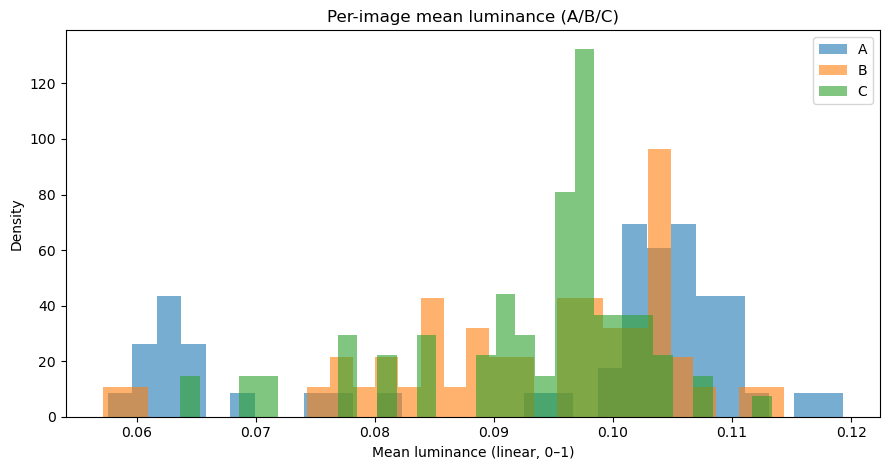

In [8]:
# luminance_compare_all_images.py
from pathlib import Path
import numpy as np
from PIL import Image
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

# ======= CONFIG =======
# Folders (default mode)
FOLDER_A = r"C:\Users\micha\Desktop\AGNG\Images\Fearful"   # Group A
FOLDER_B = r"C:\Users\micha\Desktop\AGNG\Images\Happy"     # Group B
FOLDER_C1 = r"C:\Users\micha\Desktop\AGNG\Images\Scram1"   # Part of Group C
FOLDER_C2 = r"C:\Users\micha\Desktop\AGNG\Images\Scram2"   # Part of Group C

# OPTIONAL: explicit lists of files. Set to None to use folders.
# Example: LIST_A = [r"C:\path\to\a1.png", r"C:\path\to\a2.jpg"]
LIST_A = None
LIST_B = None
LIST_C = None  # If None, we'll pool FOLDER_C1 + FOLDER_C2

# File extensions to include (semicolon-separated, supports recursive search)
GLOB_PAT = "*.png;*.jpg;*.jpeg;*.tif;*.tiff;*.bmp"

# Output CSV
OUTPUT_CSV = r"C:\Users\micha\Desktop\AGNG\Images\luminance_stats.csv"

# Plot settings
NUM_BINS = 30
PLOT_TITLE = "Per-image mean luminance (A/B/C)"
# ======================


def expand_globs(folder: str, pattern_string: str):
    """Recursively collect files in folder matching all patterns in pattern_string."""
    exts = [p.strip() for p in pattern_string.split(";") if p.strip()]
    paths = []
    base = Path(folder)
    for ext in exts:
        paths.extend(base.rglob(ext))
    # Keep only files (skip directories) and sort for stability
    return sorted([p for p in paths if p.is_file()])


def srgb_to_linear(u):
    """u in [0,1] sRGB → linear RGB (IEC 61966-2-1)."""
    u = np.asarray(u, dtype=np.float32)
    return np.where(u <= 0.04045, u / 12.92, ((u + 0.055) / 1.055) ** 2.4)


def mean_luminance_srgb(image_path, ignore_alpha=True):
    """
    Mean luminance using linearized sRGB and Rec.709 luma:
      Y = 0.2126*R + 0.7152*G + 0.0722*B  (R,G,B are *linear* in [0,1]).
    If image has alpha and ignore_alpha=False, we compute an alpha-weighted mean.
    Returns Y_mean in [0,1].
    """
    im = Image.open(image_path).convert("RGBA")  # normalize handling of alpha
    arr = np.asarray(im).astype(np.float32) / 255.0  # RGBA in [0,1]
    rgb = arr[..., :3]

    if not ignore_alpha and arr.shape[-1] == 4:
        a = arr[..., 3:4]
        rgb_lin = srgb_to_linear(rgb) * a
        Y = 0.2126 * rgb_lin[..., 0] + 0.7152 * rgb_lin[..., 1] + 0.0722 * rgb_lin[..., 2]
        denom = np.maximum(a[..., 0].sum(), 1e-8)
        return float(Y.sum() / denom)

    # Default: ignore alpha, just linearize and average
    rgb_lin = srgb_to_linear(rgb)
    Y = 0.2126 * rgb_lin[..., 0] + 0.7152 * rgb_lin[..., 1] + 0.0722 * rgb_lin[..., 2]
    return float(np.mean(Y))


def gather_list_stats(file_list, label, ignore_alpha=True):
    """Compute per-image luminance for an explicit list of files."""
    rows = []
    for p in file_list:
        try:
            y = mean_luminance_srgb(p, ignore_alpha=ignore_alpha)
            rows.append({"file": str(p), "folder": label, "mean_luminance": y})
        except Exception as e:
            rows.append({"file": str(p), "folder": label, "mean_luminance": np.nan, "error": str(e)})
            print(f"[warn] {p}: {e}")
    return pd.DataFrame(rows)


def gather_folder_stats(folder, label, pattern=GLOB_PAT, ignore_alpha=True):
    """Compute per-image luminance for all images found in a folder (recursive)."""
    files = expand_globs(folder, pattern)
    return gather_list_stats([str(p) for p in files], label, ignore_alpha=ignore_alpha)


def summarize_and_tests(df):
    """Print summary stats, omnibus tests, and pairwise Welch t-tests with Cohen's d."""
    print("\nSummary by folder:")
    summ = df.groupby("folder")["mean_luminance"].agg(["count", "mean", "std"])
    print(summ)

    # Extract arrays
    a = df.loc[(df.folder == "A") & df.mean_luminance.notna(), "mean_luminance"].to_numpy()
    b = df.loc[(df.folder == "B") & df.mean_luminance.notna(), "mean_luminance"].to_numpy()
    c = df.loc[(df.folder == "C") & df.mean_luminance.notna(), "mean_luminance"].to_numpy()

    # Omnibus tests
    print("\nOmnibus tests:")
    ok_sizes = (len(a) >= 2) and (len(b) >= 2) and (len(c) >= 2)
    if ok_sizes:
        try:
            F, pA = stats.f_oneway(a, b, c)
            print(f"One-way ANOVA: F={F:.3f}, p={pA:.3g}")
        except Exception as e:
            print(f"ANOVA failed: {e}")

        try:
            H, pK = stats.kruskal(a, b, c)
            print(f"Kruskal–Wallis: H={H:.3f}, p={pK:.3g}")
        except Exception as e:
            print(f"Kruskal–Wallis failed: {e}")
    else:
        print("Not enough data for omnibus tests (need ≥2 per group).")

    # Pairwise Welch t-tests
    def pairwise(g1, g2, l1, l2):
        if len(g1) >= 2 and len(g2) >= 2:
            t, p = stats.ttest_ind(g1, g2, equal_var=False)
            # Cohen's d (pooled SD with unequal n)
            s1 = np.var(g1, ddof=1)
            s2 = np.var(g2, ddof=1)
            n1, n2 = len(g1), len(g2)
            sp = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / max(n1 + n2 - 2, 1))
            d = (np.mean(g1) - np.mean(g2)) / sp if sp > 0 else np.nan
            print(f"{l1} vs {l2}: Welch t={t:.3f}, p={p:.3g}, d={d:.3f}")
        else:
            print(f"{l1} vs {l2}: Not enough data (need ≥2 each).")

    print("\nPlanned comparisons (Welch):")
    pairwise(a, b, "A", "B")
    pairwise(a, c, "A", "C")
    pairwise(b, c, "B", "C")

    return a, b, c


def plot_histograms(a, b, c, bins=30, title="Per-image mean luminance (A/B/C)"):
    """Plot overlaid histograms for A, B, C if data present."""
    have_any = any(len(x) > 0 for x in (a, b, c))
    if not have_any:
        print("\nNo data to plot.")
        return

    plt.figure(figsize=(9, 4.8))
    if len(a) > 0:
        plt.hist(a, bins=bins, alpha=0.6, label="A", density=True)
    if len(b) > 0:
        plt.hist(b, bins=bins, alpha=0.6, label="B", density=True)
    if len(c) > 0:
        plt.hist(c, bins=bins, alpha=0.6, label="C", density=True)

    plt.xlabel("Mean luminance (linear, 0–1)")
    plt.ylabel("Density")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


def main():
    # Decide input mode for A and B (lists take precedence if provided)
    if LIST_A is not None:
        dfA = gather_list_stats(LIST_A, "A")
    else:
        dfA = gather_folder_stats(FOLDER_A, "A")

    if LIST_B is not None:
        dfB = gather_list_stats(LIST_B, "B")
    else:
        dfB = gather_folder_stats(FOLDER_B, "B")

    # Group C: explicit list if provided, else pool the two folders
    if LIST_C is not None:
        dfC = gather_list_stats(LIST_C, "C")
    else:
        files_C = [str(p) for p in expand_globs(FOLDER_C1, GLOB_PAT)] + \
                  [str(p) for p in expand_globs(FOLDER_C2, GLOB_PAT)]
        # De-duplicate while preserving order
        seen = set()
        pooled = []
        for f in files_C:
            if f not in seen:
                seen.add(f)
                pooled.append(f)
        dfC = gather_list_stats(pooled, "C")

    # Combine and save
    df = pd.concat([dfA, dfB, dfC], ignore_index=True)
    df.to_csv(OUTPUT_CSV, index=False)
    print(f"Saved per-image luminance to:\n  {OUTPUT_CSV}")

    # Summary + tests
    a, b, c = summarize_and_tests(df)

    # Plot
    plot_histograms(a, b, c, bins=NUM_BINS, title=PLOT_TITLE)


if __name__ == "__main__":
    main()


Saved per-image luminance to C:\Users\micha\Desktop\AGNG\Images\luminance_stats.csv

Summary:
        count      mean       std
folder                           
A          35  0.092582  0.019507
B          35  0.093217  0.010017
C          35  0.092546  0.010544

Kruskal–Wallis H-test (non-parametric ANOVA):
H=3.613, p=0.164
Bootstrap A–B mean diff: -0.0007 (95% CI: -0.0080, 0.0064)

Planned comparisons:
A vs B: t=-0.171, p=0.865, Cohen's d=-0.041
A vs C: t=0.010, p=0.992, Cohen's d=0.002
B vs C: t=0.273, p=0.786, Cohen's d=0.065


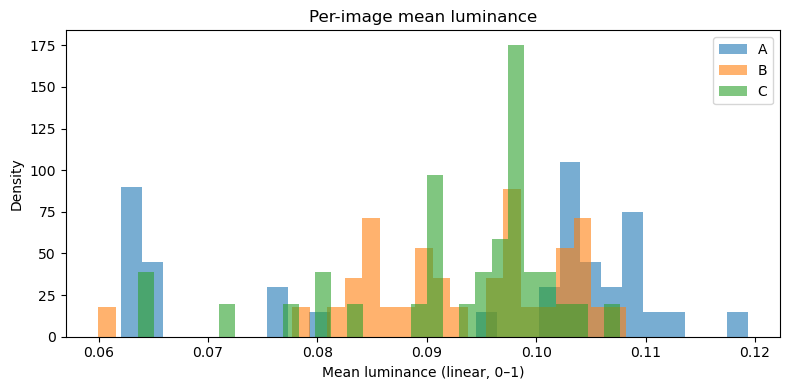

In [3]:
#No-Go V1 - Overall

# luminance_compare.py
from pathlib import Path
import numpy as np
from PIL import Image, ImageStat
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

# ======= CONFIG =======
# ======= CONFIG =======
LIST_A = [
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\HM06_FC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AF28AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AF26AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\HF04_FO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\BM03_FC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM06_FO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AF25AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\BF14_FO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\HF05_FC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM30AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM10_FO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\HF09_FC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM22AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM32AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AF28AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AF30AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\HF04_FO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM17AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AF01_FO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM09_FO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM10_FO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AF09AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\BF05_FO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AF11AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\WF04_FC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\BF07_FO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\BF09_FC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM03_FC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\BM01_FO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM04AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AF01_FO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AF02AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM02_FO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\BM02_FC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM05AFS.jpg",
]

LIST_B = [
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\BM02_HO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF01_HE.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\BF09_HO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM03_HO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\BM01_HO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF11HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM04HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF32HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM01HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM09HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\BM02_HO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM05HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM05HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF19HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\HM04_HO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF02HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF07_HO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF32HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM32HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\BM01_HO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF30HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\HF10_HE.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM24HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM06_HC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF27HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF26HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\HF09_HE.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\BF14_HO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\HM09_HO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\HF10_HE.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF28HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM23HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM10_HO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM22HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\BM08_HO.jpg",
]

LIST_C = [
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AF33NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AF01_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AF09NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\BM01_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AF07NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AF10_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\HM04_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\HF04_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AF25NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\HM06_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AF24NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AF32NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AF24NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\BM08_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AF11NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\HF04_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\HF09_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AF10_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AM03NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AM17NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AM03_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AM06_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AM02_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AF32NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AF34NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AM13NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AM23NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AF33NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AM10NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AM09_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AM04_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\BF05_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AM34NES.JPG",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AM09NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AF30NES.JPG",
]

# ======================
GLOB_PAT = "*.png;*.jpg;*.jpeg;*.tif;*.tiff;*.bmp"  # semicolon-separated
OUTPUT_CSV = r"C:\Users\micha\Desktop\AGNG\Images\luminance_stats.csv"
# ======================

def expand_globs(folder, pattern_string):
    exts = [p.strip() for p in pattern_string.split(";") if p.strip()]
    paths = []
    for ext in exts:
        paths += list(Path(folder).rglob(ext))
    return sorted(paths)

def srgb_to_linear(u):
    """u in [0,1] sRGB → linear RGB (IEC 61966-2-1)."""
    u = np.asarray(u, dtype=np.float32)
    out = np.where(u <= 0.04045, u/12.92, ((u+0.055)/1.055)**2.4)
    return out

def mean_luminance_srgb(image_path, ignore_alpha=True):
    """
    Mean luminance using linearized sRGB and Rec.709 luma:
    Y = 0.2126*R + 0.7152*G + 0.0722*B  (R,G,B are *linear* in [0,1]).
    If image has alpha and ignore_alpha=False, we premultiply by alpha.
    Returns Y_mean in [0,1].
    """
    im = Image.open(image_path).convert("RGBA")  # handle alpha consistently
    arr = np.asarray(im).astype(np.float32) / 255.0  # RGBA in [0,1]
    rgb = arr[..., :3]
    if not ignore_alpha and arr.shape[-1] == 4:
        a = arr[..., 3:4]
        # premultiply RGB where alpha present, and normalize by mean alpha>0
        rgb = rgb * a
        # avoid division by zero later—leave as premultiplied average
        denom = np.maximum(a, 1e-8)

    # convert sRGB → linear
    rgb_lin = srgb_to_linear(rgb)

    # Rec.709 luminance
    Y = 0.2126 * rgb_lin[..., 0] + 0.7152 * rgb_lin[..., 1] + 0.0722 * rgb_lin[..., 2]

    if not ignore_alpha and arr.shape[-1] == 4:
        Y_mean = (Y * a[...,0]).sum() / np.maximum(a[...,0].sum(), 1e-8)
    else:
        Y_mean = float(np.mean(Y))

    return Y_mean

def gather_list_stats(file_list, label):
    rows = []
    for p in file_list:
        try:
            y = mean_luminance_srgb(p)
            rows.append({"file": p, "folder": label, "mean_luminance": y})
        except Exception as e:
            rows.append({"file": p, "folder": label, "mean_luminance": np.nan})
            print(f"[warn] {p}: {e}")
    return pd.DataFrame(rows)

def main():
    dfA = gather_list_stats(LIST_A, "A")
    dfB = gather_list_stats(LIST_B, "B")
    dfC = gather_list_stats(LIST_C, "C")
    df = pd.concat([dfA, dfB, dfC], ignore_index=True)
    df.to_csv(OUTPUT_CSV, index=False)
    print(f"Saved per-image luminance to {OUTPUT_CSV}")

    # Summary
    summ = df.groupby("folder")["mean_luminance"].agg(["count", "mean", "std"])
    print("\nSummary:")
    print(summ)

    # Function for pairwise comparison
    def compare_groups(g1, g2, label1, label2):
        if len(g1) >= 2 and len(g2) >= 2:
            t, p = stats.ttest_ind(g1, g2, equal_var=False)
            s_pooled = np.sqrt(((g1.var(ddof=1)*(len(g1)-1)) + (g2.var(ddof=1)*(len(g2)-1))) / (len(g1)+len(g2)-2))
            d = (g1.mean() - g2.mean()) / s_pooled if s_pooled > 0 else np.nan
            print(f"{label1} vs {label2}: t={t:.3f}, p={p:.3g}, Cohen's d={d:.3f}")
        else:
            print(f"{label1} vs {label2}: Not enough data.")

    # Extract arrays
    a = df.loc[df.folder == "A", "mean_luminance"].dropna().to_numpy()
    b = df.loc[df.folder == "B", "mean_luminance"].dropna().to_numpy()
    c = df.loc[df.folder == "C", "mean_luminance"].dropna().to_numpy()

        # Non-parametric omnibus test
    print("\nKruskal–Wallis H-test (non-parametric ANOVA):")
    H, p_kw = stats.kruskal(a, b, c)
    print(f"H={H:.3f}, p={p_kw:.3g}")

    # Example bootstrap for A vs B mean difference
    def bootstrap_mean_diff(x, y, n_iter=10000, seed=42):
        rng = np.random.default_rng(seed)
        diffs = []
        for _ in range(n_iter):
            xb = rng.choice(x, size=len(x), replace=True)
            yb = rng.choice(y, size=len(y), replace=True)
            diffs.append(xb.mean() - yb.mean())
        return np.array(diffs)

    diffs_ab = bootstrap_mean_diff(a, b)
    ci_lower, ci_upper = np.percentile(diffs_ab, [2.5, 97.5])
    print(f"Bootstrap A–B mean diff: {diffs_ab.mean():.4f} "
          f"(95% CI: {ci_lower:.4f}, {ci_upper:.4f})")
    
    # Planned comparisons
    print("\nPlanned comparisons:")
    compare_groups(a, b, "A", "B")
    compare_groups(a, c, "A", "C")
    compare_groups(b, c, "B", "C")

    # Plot distributions
    plt.figure(figsize=(8, 4))
    plt.hist(a, bins=30, alpha=0.6, label="A", density=True)
    plt.hist(b, bins=30, alpha=0.6, label="B", density=True)
    plt.hist(c, bins=30, alpha=0.6, label="C", density=True)
    plt.xlabel("Mean luminance (linear, 0–1)")
    plt.ylabel("Density")
    plt.title("Per-image mean luminance")
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


Saved per-image luminance to C:\Users\micha\Desktop\AGNG\Images\luminance_stats.csv

Summary:
        count      mean       std
folder                           
A          35  0.092788  0.019479
B          35  0.094044  0.010650
C          35  0.092589  0.011908

Kruskal–Wallis H-test (non-parametric ANOVA):
H=2.902, p=0.234
Bootstrap A–B mean diff: -0.0012 (95% CI: -0.0086, 0.0060)

Planned comparisons:
A vs B: t=-0.335, p=0.739, Cohen's d=-0.080
A vs C: t=0.052, p=0.959, Cohen's d=0.012
B vs C: t=0.539, p=0.592, Cohen's d=0.129


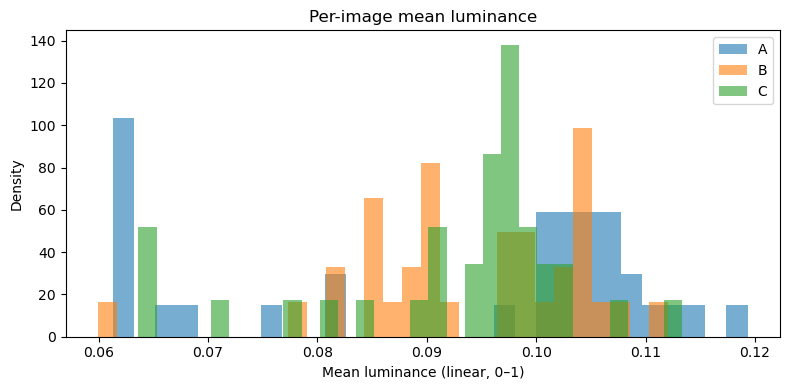

In [4]:
#No-Go V2 - Overall

# luminance_compare.py
from pathlib import Path
import numpy as np
from PIL import Image, ImageStat
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

# ======= CONFIG =======
LIST_A = [
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\BF18_FC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\BF14_FO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\WM12_FO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM30AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AF30AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\HF04_FO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\HM06_FC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AF28AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AF26AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM05AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\BM03_FC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM06_FO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM10_FO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AF21AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM22AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM17AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM05AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM09AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM03AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM09AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM04AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM05AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AF01_FO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\BF07_FO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\BF09_FC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\HF04_FO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM06_FO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM04_FO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AF09AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\BF05_FO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\HM09_FC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AF02AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM02_FO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\BM02_FC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM23AFS.jpg",
]

LIST_B = [
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM04HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF25HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM01HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF32HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\BM02_HO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM17HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM05HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\BM01_HO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\HM06_HO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF02HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF07_HO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM32HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF01_HE.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\BF09_HO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\BM01_HO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF09HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM17HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF23HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\HF09_HE.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\BM08_HO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\BF14_HO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\HM09_HO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM04HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF28HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF19HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM10_HO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM22HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF32HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM32HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\BM01_HO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF30HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\BF10_HO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM24HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM06_HC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF27HAS.jpg",
]

LIST_C = [
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AF07_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AF33NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AF01_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AF09NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AF07NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\HM04_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AF07NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\HM04_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\HF04_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AF25NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\HM06_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AF07NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AF33NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AF01_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AM22NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\BM01_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AF07NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AF07NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AM09_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AM04_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\BF05_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AM02_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AF32NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AM09NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AF30NES.JPG",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AM03NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AM17NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AM03_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AM06_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AM34NES.JPG",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AF34NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AM13NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AM23NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AF33NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AM10NES.jpg",
]
# ======================
GLOB_PAT = "*.png;*.jpg;*.jpeg;*.tif;*.tiff;*.bmp"  # semicolon-separated
OUTPUT_CSV = r"C:\Users\micha\Desktop\AGNG\Images\luminance_stats.csv"
# ======================

def expand_globs(folder, pattern_string):
    exts = [p.strip() for p in pattern_string.split(";") if p.strip()]
    paths = []
    for ext in exts:
        paths += list(Path(folder).rglob(ext))
    return sorted(paths)

def srgb_to_linear(u):
    """u in [0,1] sRGB → linear RGB (IEC 61966-2-1)."""
    u = np.asarray(u, dtype=np.float32)
    out = np.where(u <= 0.04045, u/12.92, ((u+0.055)/1.055)**2.4)
    return out

def mean_luminance_srgb(image_path, ignore_alpha=True):
    """
    Mean luminance using linearized sRGB and Rec.709 luma:
    Y = 0.2126*R + 0.7152*G + 0.0722*B  (R,G,B are *linear* in [0,1]).
    If image has alpha and ignore_alpha=False, we premultiply by alpha.
    Returns Y_mean in [0,1].
    """
    im = Image.open(image_path).convert("RGBA")  # handle alpha consistently
    arr = np.asarray(im).astype(np.float32) / 255.0  # RGBA in [0,1]
    rgb = arr[..., :3]
    if not ignore_alpha and arr.shape[-1] == 4:
        a = arr[..., 3:4]
        # premultiply RGB where alpha present, and normalize by mean alpha>0
        rgb = rgb * a
        # avoid division by zero later—leave as premultiplied average
        denom = np.maximum(a, 1e-8)

    # convert sRGB → linear
    rgb_lin = srgb_to_linear(rgb)

    # Rec.709 luminance
    Y = 0.2126 * rgb_lin[..., 0] + 0.7152 * rgb_lin[..., 1] + 0.0722 * rgb_lin[..., 2]

    if not ignore_alpha and arr.shape[-1] == 4:
        Y_mean = (Y * a[...,0]).sum() / np.maximum(a[...,0].sum(), 1e-8)
    else:
        Y_mean = float(np.mean(Y))

    return Y_mean

def gather_list_stats(file_list, label):
    rows = []
    for p in file_list:
        try:
            y = mean_luminance_srgb(p)
            rows.append({"file": p, "folder": label, "mean_luminance": y})
        except Exception as e:
            rows.append({"file": p, "folder": label, "mean_luminance": np.nan})
            print(f"[warn] {p}: {e}")
    return pd.DataFrame(rows)

def main():
    dfA = gather_list_stats(LIST_A, "A")
    dfB = gather_list_stats(LIST_B, "B")
    dfC = gather_list_stats(LIST_C, "C")
    df = pd.concat([dfA, dfB, dfC], ignore_index=True)
    df.to_csv(OUTPUT_CSV, index=False)
    print(f"Saved per-image luminance to {OUTPUT_CSV}")

    # Summary
    summ = df.groupby("folder")["mean_luminance"].agg(["count", "mean", "std"])
    print("\nSummary:")
    print(summ)

    # Function for pairwise comparison
    def compare_groups(g1, g2, label1, label2):
        if len(g1) >= 2 and len(g2) >= 2:
            t, p = stats.ttest_ind(g1, g2, equal_var=False)
            s_pooled = np.sqrt(((g1.var(ddof=1)*(len(g1)-1)) + (g2.var(ddof=1)*(len(g2)-1))) / (len(g1)+len(g2)-2))
            d = (g1.mean() - g2.mean()) / s_pooled if s_pooled > 0 else np.nan
            print(f"{label1} vs {label2}: t={t:.3f}, p={p:.3g}, Cohen's d={d:.3f}")
        else:
            print(f"{label1} vs {label2}: Not enough data.")

    # Extract arrays
    a = df.loc[df.folder == "A", "mean_luminance"].dropna().to_numpy()
    b = df.loc[df.folder == "B", "mean_luminance"].dropna().to_numpy()
    c = df.loc[df.folder == "C", "mean_luminance"].dropna().to_numpy()

        # Non-parametric omnibus test
    print("\nKruskal–Wallis H-test (non-parametric ANOVA):")
    H, p_kw = stats.kruskal(a, b, c)
    print(f"H={H:.3f}, p={p_kw:.3g}")

    # Example bootstrap for A vs B mean difference
    def bootstrap_mean_diff(x, y, n_iter=10000, seed=42):
        rng = np.random.default_rng(seed)
        diffs = []
        for _ in range(n_iter):
            xb = rng.choice(x, size=len(x), replace=True)
            yb = rng.choice(y, size=len(y), replace=True)
            diffs.append(xb.mean() - yb.mean())
        return np.array(diffs)

    diffs_ab = bootstrap_mean_diff(a, b)
    ci_lower, ci_upper = np.percentile(diffs_ab, [2.5, 97.5])
    print(f"Bootstrap A–B mean diff: {diffs_ab.mean():.4f} "
          f"(95% CI: {ci_lower:.4f}, {ci_upper:.4f})")
    
    # Planned comparisons
    print("\nPlanned comparisons:")
    compare_groups(a, b, "A", "B")
    compare_groups(a, c, "A", "C")
    compare_groups(b, c, "B", "C")

    # Plot distributions
    plt.figure(figsize=(8, 4))
    plt.hist(a, bins=30, alpha=0.6, label="A", density=True)
    plt.hist(b, bins=30, alpha=0.6, label="B", density=True)
    plt.hist(c, bins=30, alpha=0.6, label="C", density=True)
    plt.xlabel("Mean luminance (linear, 0–1)")
    plt.ylabel("Density")
    plt.title("Per-image mean luminance")
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

Saved per-image luminance to C:\Users\micha\Desktop\AGNG\Images\luminance_stats.csv

Summary:
        count      mean       std
folder                           
A         105  0.094784  0.018576
B         105  0.093193  0.012391
C         105  0.093685  0.009486

Kruskal–Wallis H-test (non-parametric ANOVA):
H=21.519, p=2.12e-05
Bootstrap A–B mean diff: 0.0016 (95% CI: -0.0027, 0.0058)

Planned comparisons:
A vs B: t=0.730, p=0.466, Cohen's d=0.101
A vs C: t=0.540, p=0.59, Cohen's d=0.075
B vs C: t=-0.323, p=0.747, Cohen's d=-0.045


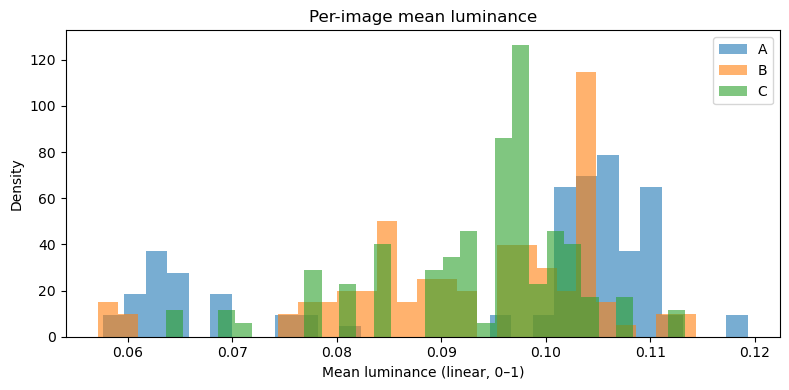

In [5]:
#Go V1 - Overall

# luminance_compare.py
from pathlib import Path
import numpy as np
from PIL import Image, ImageStat
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

# ======= CONFIG =======
# ======= CONFIG =======
LIST_A = [
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\BM01_FO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\HF04_FO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AF22AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\BF07_FO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\BF10_FO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AF01_FO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\BF18_FC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AF02AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\HF09_FC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM23AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\BF09_FC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\WF11_FC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\BM03_FC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AF19AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AF02AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\HF05_FC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\BF05_FO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\WF05_FO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM10_FO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AF21AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\HM09_FC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM03_FC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\BM02_FC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\HF10_FO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AF28AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM30AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM19AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM13AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM09AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AF09AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AF11AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AF30AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AF26AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\WM11_FC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM05AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM22AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM10AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AF07FS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM03AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\WF04_FC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AF25AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\HM09_FC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\BF14_FO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM10_FO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\HM06_FC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM02_FO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM17AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM32AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\WM12_FO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM24AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AF01_FO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\WF04_FC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM23AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\BM02_FC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\HF05_FC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AF07FS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM30AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\HM06_FC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AF19AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AF25AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AF30AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM06_FO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AF21AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AF01_FO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\BM03_FC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\HM09_FC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM10_FO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AF11AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM10_FO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\WF04_FC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AF28AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\WF11_FC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM17AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\BF10_FO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\HF04_FO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM23AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\WF05_FO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM03_FC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM17AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\HM09_FC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\BF18_FC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\WF04_FC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM24AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM03AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\BM08_FC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AF32AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AF26AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\BF09_FC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\BM01_FO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\WM11_FC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM02_FO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AF09AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM23AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM05AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\BF14_FO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AF02AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM32AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM09_FO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AF01_FO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM22AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM19AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AF22AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM13AFS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\HF09_FC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM04AFS.jpg",
]

LIST_B = [
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF02HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF28HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF22HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM24HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\WM11_HC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\BM01_HO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\BF05_HO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM10HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM09HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF07_HO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF27HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\HF10_HE.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\BF14_HO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM01HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF11HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\BM01_HO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF07_HO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\HM06_HO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF09HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM04HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\BF07_HO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF02HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM32HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\BF05_HO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\BF09_HO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM06_HC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM23HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\BM01_HO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF25HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\BM08_HO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF32HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF25HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM32HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\BM02_HO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM10_HO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF19HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM06_HC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\WF11_HE.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\HF09_HE.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM17HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\HF10_HE.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM04_HE.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF32HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF01_HE.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\HM04_HO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM22HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF26HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF25HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\BM02_HO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\WF05_HC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM17HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM17HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF30HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\BF09_HO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF30HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF27HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF22HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\WM11_HC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\BF05_HO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF23HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM16HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM04HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF26HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\HM04_HO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM10HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM24HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF01_HE.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM10_HO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF09HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\BM02_HO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM10_HO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF07_HO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\BM01_HO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\BF09_HO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM05HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\HF10_HE.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\BF07_HO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF02HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM23HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM09HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM10HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF32HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM03_HO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM05HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF02HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\BM08_HO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM22HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM23HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\WM12_HE.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\HF10_HE.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\HM09_HO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF07_HO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM17HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\HF09_HE.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\WF11_HE.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF19HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\HM06_HO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\HF05_HO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF21HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM06_HC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF25HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM32HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM04_HE.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF28HAS.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF07_HO.jpg",
]

LIST_C = [
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AM10NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\BM08_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AF11NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AF34NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AM03NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\BF05_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\HF10_NO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AF10_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\HM04_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AM02_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\BF10_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AM09_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AM03_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AF33NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AF07_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AM23NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AF09NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\HM06_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AF30NES.JPG",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AF34NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\BM01_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\BF07_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\BF05_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AM03_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\HF09_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AM31NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AM04_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AM09_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AM02_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AM23NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AM03NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AF01_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AM10NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AM13NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AF07NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AF32NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AM05NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AM04_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AM34NES.JPG",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AM17NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AM17NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\BF07_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AM09NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\HF05_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\BF14_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\BF14_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AM22NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AF24NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AM34NES.JPG",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\BF10_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\BF18_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AF25NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\HM09_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\HM06_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AM31NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\BM01_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\HM09_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\BF07_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\BF14_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AF10_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AF01_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AF24NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\BF14_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AM13NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\HM04_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AM03NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AM22NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AM10NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\HF09_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\BM08_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AF32NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AM06_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\HF05_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\HM04_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AF25NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AF34NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AF11NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AM02_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AM03_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AF33NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\BF10_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AF07_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AF24NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AF25NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\BF10_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\BF18_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\HF09_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\BF05_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AM17NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AF09NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\HM06_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AF07NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\BM01_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AF07_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AF10_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AM09NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AF01_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AM09_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AF11NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\BF07_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AM04_NC.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AM23NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\HF10_NO.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AF07NES.jpg",
    r"C:\Users\micha\Desktop\AGNG\Images\Scram2\BM08_NC.jpg",
]

# ======================
GLOB_PAT = "*.png;*.jpg;*.jpeg;*.tif;*.tiff;*.bmp"  # semicolon-separated
OUTPUT_CSV = r"C:\Users\micha\Desktop\AGNG\Images\luminance_stats.csv"
# ======================

def expand_globs(folder, pattern_string):
    exts = [p.strip() for p in pattern_string.split(";") if p.strip()]
    paths = []
    for ext in exts:
        paths += list(Path(folder).rglob(ext))
    return sorted(paths)

def srgb_to_linear(u):
    """u in [0,1] sRGB → linear RGB (IEC 61966-2-1)."""
    u = np.asarray(u, dtype=np.float32)
    out = np.where(u <= 0.04045, u/12.92, ((u+0.055)/1.055)**2.4)
    return out

def mean_luminance_srgb(image_path, ignore_alpha=True):
    """
    Mean luminance using linearized sRGB and Rec.709 luma:
    Y = 0.2126*R + 0.7152*G + 0.0722*B  (R,G,B are *linear* in [0,1]).
    If image has alpha and ignore_alpha=False, we premultiply by alpha.
    Returns Y_mean in [0,1].
    """
    im = Image.open(image_path).convert("RGBA")  # handle alpha consistently
    arr = np.asarray(im).astype(np.float32) / 255.0  # RGBA in [0,1]
    rgb = arr[..., :3]
    if not ignore_alpha and arr.shape[-1] == 4:
        a = arr[..., 3:4]
        # premultiply RGB where alpha present, and normalize by mean alpha>0
        rgb = rgb * a
        # avoid division by zero later—leave as premultiplied average
        denom = np.maximum(a, 1e-8)

    # convert sRGB → linear
    rgb_lin = srgb_to_linear(rgb)

    # Rec.709 luminance
    Y = 0.2126 * rgb_lin[..., 0] + 0.7152 * rgb_lin[..., 1] + 0.0722 * rgb_lin[..., 2]

    if not ignore_alpha and arr.shape[-1] == 4:
        Y_mean = (Y * a[...,0]).sum() / np.maximum(a[...,0].sum(), 1e-8)
    else:
        Y_mean = float(np.mean(Y))

    return Y_mean

def gather_list_stats(file_list, label):
    rows = []
    for p in file_list:
        try:
            y = mean_luminance_srgb(p)
            rows.append({"file": p, "folder": label, "mean_luminance": y})
        except Exception as e:
            rows.append({"file": p, "folder": label, "mean_luminance": np.nan})
            print(f"[warn] {p}: {e}")
    return pd.DataFrame(rows)

def main():
    dfA = gather_list_stats(LIST_A, "A")
    dfB = gather_list_stats(LIST_B, "B")
    dfC = gather_list_stats(LIST_C, "C")
    df = pd.concat([dfA, dfB, dfC], ignore_index=True)
    df.to_csv(OUTPUT_CSV, index=False)
    print(f"Saved per-image luminance to {OUTPUT_CSV}")

    # Summary
    summ = df.groupby("folder")["mean_luminance"].agg(["count", "mean", "std"])
    print("\nSummary:")
    print(summ)

    # Function for pairwise comparison
    def compare_groups(g1, g2, label1, label2):
        if len(g1) >= 2 and len(g2) >= 2:
            t, p = stats.ttest_ind(g1, g2, equal_var=False)
            s_pooled = np.sqrt(((g1.var(ddof=1)*(len(g1)-1)) + (g2.var(ddof=1)*(len(g2)-1))) / (len(g1)+len(g2)-2))
            d = (g1.mean() - g2.mean()) / s_pooled if s_pooled > 0 else np.nan
            print(f"{label1} vs {label2}: t={t:.3f}, p={p:.3g}, Cohen's d={d:.3f}")
        else:
            print(f"{label1} vs {label2}: Not enough data.")

    # Extract arrays
    a = df.loc[df.folder == "A", "mean_luminance"].dropna().to_numpy()
    b = df.loc[df.folder == "B", "mean_luminance"].dropna().to_numpy()
    c = df.loc[df.folder == "C", "mean_luminance"].dropna().to_numpy()

        # Non-parametric omnibus test
    print("\nKruskal–Wallis H-test (non-parametric ANOVA):")
    H, p_kw = stats.kruskal(a, b, c)
    print(f"H={H:.3f}, p={p_kw:.3g}")

    # Example bootstrap for A vs B mean difference
    def bootstrap_mean_diff(x, y, n_iter=10000, seed=42):
        rng = np.random.default_rng(seed)
        diffs = []
        for _ in range(n_iter):
            xb = rng.choice(x, size=len(x), replace=True)
            yb = rng.choice(y, size=len(y), replace=True)
            diffs.append(xb.mean() - yb.mean())
        return np.array(diffs)

    diffs_ab = bootstrap_mean_diff(a, b)
    ci_lower, ci_upper = np.percentile(diffs_ab, [2.5, 97.5])
    print(f"Bootstrap A–B mean diff: {diffs_ab.mean():.4f} "
          f"(95% CI: {ci_lower:.4f}, {ci_upper:.4f})")
    
    # Planned comparisons
    print("\nPlanned comparisons:")
    compare_groups(a, b, "A", "B")
    compare_groups(a, c, "A", "C")
    compare_groups(b, c, "B", "C")

    # Plot distributions
    plt.figure(figsize=(8, 4))
    plt.hist(a, bins=30, alpha=0.6, label="A", density=True)
    plt.hist(b, bins=30, alpha=0.6, label="B", density=True)
    plt.hist(c, bins=30, alpha=0.6, label="C", density=True)
    plt.xlabel("Mean luminance (linear, 0–1)")
    plt.ylabel("Density")
    plt.title("Per-image mean luminance")
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


Saved per-image luminance to C:\Users\micha\Desktop\AGNG\Images\luminance_stats.csv

Summary:
        count      mean       std
folder                           
A          48  0.092744  0.019627
B         105  0.092450  0.012982
C         105  0.092590  0.010396

Kruskal–Wallis H-test (non-parametric ANOVA):
H=7.638, p=0.022
Bootstrap A–B mean diff: 0.0003 (95% CI: -0.0059, 0.0063)

Planned comparisons:
A vs B: t=0.095, p=0.925, Cohen's d=0.019
A vs C: t=0.051, p=0.959, Cohen's d=0.011
B vs C: t=-0.086, p=0.931, Cohen's d=-0.012


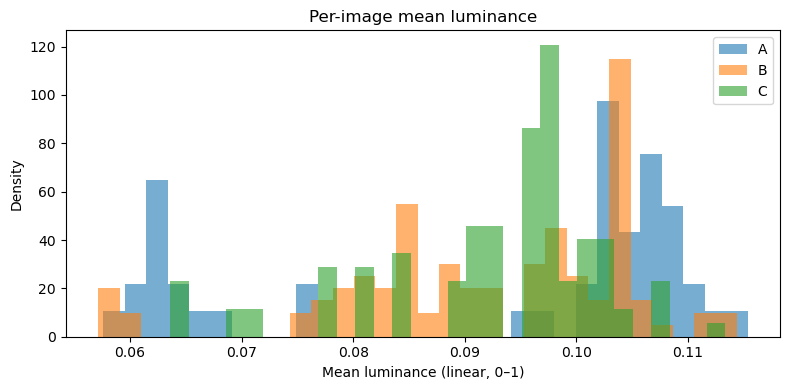

In [6]:
#Go V2 - Overall

# luminance_compare.py
from pathlib import Path
import numpy as np
from PIL import Image, ImageStat
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

# ======= CONFIG =======
# ======= CONFIG =======
LIST_A = [
r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AF26AFS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Fearful\WM11_FC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM05AFS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM22AFS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM10AFS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AF07FS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM03AFS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AF01_FO.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AF25AFS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AF28AFS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM30AFS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM19AFS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM13AFS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM09AFS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AF09AFS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AF11AFS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AF30AFS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM24AFS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Fearful\HF04_FO.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Fearful\WF04_FC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM23AFS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Fearful\BM01_FO.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Fearful\HF04_FO.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AF22AFS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Fearful\BF07_FO.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Fearful\BF10_FO.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AF01_FO.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Fearful\BF18_FC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AF28AFS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Fearful\HF09_FC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM16AFS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Fearful\BF09_FC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Fearful\WF11_FC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Fearful\BM03_FC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AF19AFS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AF02AFS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Fearful\HF05_FC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Fearful\BF05_FO.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Fearful\WF05_FO.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM10_FO.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AF21AFS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Fearful\HM09_FC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM03_FC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Fearful\BM02_FC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Fearful\HF10_FO.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Fearful\HM06_FC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Fearful\BF14_FO.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Fearful\AM04_FO.jpg",
]

LIST_B = [
  r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM32HAS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\BF05_HO.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\BF09_HO.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM06_HC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM23HAS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\BM01_HO.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF25HAS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\BM08_HO.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF32HAS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF25HAS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM32HAS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF01_HE.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\HM04_HO.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM22HAS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF26HAS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF25HAS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\BM02_HO.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\WF05_HC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM23HAS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM17HAS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF30HAS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF02HAS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF28HAS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF22HAS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM24HAS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\WM11_HC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\BM01_HO.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\BF05_HO.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM10HAS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM09HAS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF07_HO.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF27HAS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\HF10_HE.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\BF14_HO.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM01HAS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF11HAS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\BM01_HO.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF07_HO.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\HM06_HO.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF09HAS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM04HAS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\BF07_HO.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF02HAS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\BM02_HO.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM10_HO.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF19HAS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM06_HC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\WF11_HE.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\HF09_HE.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM17HAS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\HF10_HE.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM04_HE.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF32HAS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\BF09_HO.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF30HAS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF27HAS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF22HAS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\WM11_HC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\BF05_HO.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF25HAS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM16HAS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM04HAS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\HF09_HE.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM17HAS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\HF09_HE.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\WF11_HE.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF19HAS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM24HAS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF01_HE.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM10_HO.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF09HAS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\BM02_HO.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM06_HC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF10_HE.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\BM01_HO.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\BF05_HO.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF19HAS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\HF10_HE.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\BF07_HO.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF32HAS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM23HAS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM09HAS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM10HAS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF02HAS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\BM01_HO.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM05HAS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF02HAS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\BM08_HO.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM22HAS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM32HAS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\WM12_HE.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\HF10_HE.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\HM09_HO.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF26HAS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\HM04_HO.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM17HAS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\HM06_HO.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF25HAS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF21HAS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM06_HC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF25HAS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM32HAS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\AM04_HE.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF28HAS.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Happy\AF07_HO.jpg",
]

LIST_C = [
r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AM10NES.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram2\BM08_NC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AF11NES.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AM03NES.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram1\BF05_NC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram2\HF10_NO.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AM03_NC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AF33NES.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AF07_NC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AM23NES.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AF09NES.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram2\HM06_NC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AF33NES.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AF07_NC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AM23NES.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AF09NES.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram2\HM06_NC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AF30NES.JPG",
r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AF34NES.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram2\BM01_NC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram2\BF07_NC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram2\BF05_NC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AM03_NC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram2\HF09_NC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AM31NES.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AM13NES.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AM09_NC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AM02_NC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AM23NES.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AM10NES.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram2\BM08_NC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AF11NES.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AF34NES.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AM03NES.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram1\BF05_NC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram2\HF10_NO.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AF10_NC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram2\HM04_NC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AM02_NC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram1\BF10_NC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AM09_NC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram2\BF07_NC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AF10_NC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram2\HM04_NC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AM02_NC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram1\BF10_NC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AM09_NC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AM06_NC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AM03_NC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AF33NES.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AF34NES.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram2\BM01_NC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AM17NES.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AF09NES.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram1\HM06_NC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AF07NES.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram1\BM01_NC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AF07_NC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AF10_NC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AM06_NC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram2\HF05_NC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram2\HM04_NC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AF25NES.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AF34NES.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AM23NES.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram2\HF10_NO.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AF07NES.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram2\BM08_NC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram2\HM09_NC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram2\HM06_NC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AM31NES.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram2\BM01_NC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram1\HM09_NC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram2\BF07_NC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram1\BF14_NC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AF10_NC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AF01_NC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AF24NES.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram2\BF14_NC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AM13NES.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram1\HM04_NC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AM03NES.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AM22NES.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AM10NES.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram1\HF09_NC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram1\BM08_NC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AF32NES.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AM09NES.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AF01_NC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AM09_NC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AF11NES.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram1\BF07_NC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AM04_NC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram2\AF11NES.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AM02_NC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AM03_NC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AF33NES.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram1\BF10_NC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AF07_NC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AF24NES.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram1\AF25NES.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram2\BF10_NC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram1\BF18_NC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram2\HF09_NC.jpg",
r"C:\Users\micha\Desktop\AGNG\Images\Scram1\BF05_NC.jpg",
]

# ======================
GLOB_PAT = "*.png;*.jpg;*.jpeg;*.tif;*.tiff;*.bmp"  # semicolon-separated
OUTPUT_CSV = r"C:\Users\micha\Desktop\AGNG\Images\luminance_stats.csv"
# ======================

def expand_globs(folder, pattern_string):
    exts = [p.strip() for p in pattern_string.split(";") if p.strip()]
    paths = []
    for ext in exts:
        paths += list(Path(folder).rglob(ext))
    return sorted(paths)

def srgb_to_linear(u):
    """u in [0,1] sRGB → linear RGB (IEC 61966-2-1)."""
    u = np.asarray(u, dtype=np.float32)
    out = np.where(u <= 0.04045, u/12.92, ((u+0.055)/1.055)**2.4)
    return out

def mean_luminance_srgb(image_path, ignore_alpha=True):
    """
    Mean luminance using linearized sRGB and Rec.709 luma:
    Y = 0.2126*R + 0.7152*G + 0.0722*B  (R,G,B are *linear* in [0,1]).
    If image has alpha and ignore_alpha=False, we premultiply by alpha.
    Returns Y_mean in [0,1].
    """
    im = Image.open(image_path).convert("RGBA")  # handle alpha consistently
    arr = np.asarray(im).astype(np.float32) / 255.0  # RGBA in [0,1]
    rgb = arr[..., :3]
    if not ignore_alpha and arr.shape[-1] == 4:
        a = arr[..., 3:4]
        # premultiply RGB where alpha present, and normalize by mean alpha>0
        rgb = rgb * a
        # avoid division by zero later—leave as premultiplied average
        denom = np.maximum(a, 1e-8)

    # convert sRGB → linear
    rgb_lin = srgb_to_linear(rgb)

    # Rec.709 luminance
    Y = 0.2126 * rgb_lin[..., 0] + 0.7152 * rgb_lin[..., 1] + 0.0722 * rgb_lin[..., 2]

    if not ignore_alpha and arr.shape[-1] == 4:
        Y_mean = (Y * a[...,0]).sum() / np.maximum(a[...,0].sum(), 1e-8)
    else:
        Y_mean = float(np.mean(Y))

    return Y_mean

def gather_list_stats(file_list, label):
    rows = []
    for p in file_list:
        try:
            y = mean_luminance_srgb(p)
            rows.append({"file": p, "folder": label, "mean_luminance": y})
        except Exception as e:
            rows.append({"file": p, "folder": label, "mean_luminance": np.nan})
            print(f"[warn] {p}: {e}")
    return pd.DataFrame(rows)

def main():
    dfA = gather_list_stats(LIST_A, "A")
    dfB = gather_list_stats(LIST_B, "B")
    dfC = gather_list_stats(LIST_C, "C")
    df = pd.concat([dfA, dfB, dfC], ignore_index=True)
    df.to_csv(OUTPUT_CSV, index=False)
    print(f"Saved per-image luminance to {OUTPUT_CSV}")

    # Summary
    summ = df.groupby("folder")["mean_luminance"].agg(["count", "mean", "std"])
    print("\nSummary:")
    print(summ)

    # Function for pairwise comparison
    def compare_groups(g1, g2, label1, label2):
        if len(g1) >= 2 and len(g2) >= 2:
            t, p = stats.ttest_ind(g1, g2, equal_var=False)
            s_pooled = np.sqrt(((g1.var(ddof=1)*(len(g1)-1)) + (g2.var(ddof=1)*(len(g2)-1))) / (len(g1)+len(g2)-2))
            d = (g1.mean() - g2.mean()) / s_pooled if s_pooled > 0 else np.nan
            print(f"{label1} vs {label2}: t={t:.3f}, p={p:.3g}, Cohen's d={d:.3f}")
        else:
            print(f"{label1} vs {label2}: Not enough data.")

    # Extract arrays
    a = df.loc[df.folder == "A", "mean_luminance"].dropna().to_numpy()
    b = df.loc[df.folder == "B", "mean_luminance"].dropna().to_numpy()
    c = df.loc[df.folder == "C", "mean_luminance"].dropna().to_numpy()

        # Non-parametric omnibus test
    print("\nKruskal–Wallis H-test (non-parametric ANOVA):")
    H, p_kw = stats.kruskal(a, b, c)
    print(f"H={H:.3f}, p={p_kw:.3g}")

    # Example bootstrap for A vs B mean difference
    def bootstrap_mean_diff(x, y, n_iter=10000, seed=42):
        rng = np.random.default_rng(seed)
        diffs = []
        for _ in range(n_iter):
            xb = rng.choice(x, size=len(x), replace=True)
            yb = rng.choice(y, size=len(y), replace=True)
            diffs.append(xb.mean() - yb.mean())
        return np.array(diffs)

    diffs_ab = bootstrap_mean_diff(a, b)
    ci_lower, ci_upper = np.percentile(diffs_ab, [2.5, 97.5])
    print(f"Bootstrap A–B mean diff: {diffs_ab.mean():.4f} "
          f"(95% CI: {ci_lower:.4f}, {ci_upper:.4f})")
    
    # Planned comparisons
    print("\nPlanned comparisons:")
    compare_groups(a, b, "A", "B")
    compare_groups(a, c, "A", "C")
    compare_groups(b, c, "B", "C")

    # Plot distributions
    plt.figure(figsize=(8, 4))
    plt.hist(a, bins=30, alpha=0.6, label="A", density=True)
    plt.hist(b, bins=30, alpha=0.6, label="B", density=True)
    plt.hist(c, bins=30, alpha=0.6, label="C", density=True)
    plt.xlabel("Mean luminance (linear, 0–1)")
    plt.ylabel("Density")
    plt.title("Per-image mean luminance")
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


In [7]:
import pandas as pd
from pathlib import Path

COND_PATH = r"C:\Users\micha\Desktop\AGNG\Conditions\Version_1\YellowHappyStop.xlsx"
LUM_PATH  = r"C:\Users\micha\Desktop\AGNG\Images\luminance_stats.csv"
OUT_PATH  = r"C:\Users\micha\Desktop\AGNG\Conditions\Version_1\YellowHappyStop.xlsx"

# Load Excel condition file
cond = pd.read_excel(COND_PATH)

# Load luminance CSV
lum  = pd.read_csv(LUM_PATH)

# Create filename key
cond["fname"] = cond["FaceE"].apply(lambda p: Path(str(p)).name)
lum["fname"]  = lum["file"].apply(lambda p: Path(str(p)).name)

# If duplicates exist in luminance, average them
lum_agg = lum.groupby("fname", as_index=False)["mean_luminance"].mean()

# Merge and add luminance
out = cond.merge(lum_agg, on="fname", how="left") \
          .rename(columns={"mean_luminance": "FaceE_Luminance"})

# Drop helper col and save back to Excel
out = out.drop(columns=["fname"])
out.to_excel(OUT_PATH, index=False)

print(f"Saved: {OUT_PATH}")
print(out.head())

Saved: C:\Users\micha\Desktop\AGNG\Conditions\Version_1\YellowHappyStop.xlsx
   Trial_No                       FaceE Express ColourT Trial_Type  \
0         1  Images/Fearful/BM02_FC.jpg    Fear    Blue         Go   
1         2  Images/Fearful/HF05_FC.jpg    Fear    Blue         Go   
2         3    Images/Happy/AF32HAS.jpg   Happy  Yellow    Inhibit   
3         4    Images/Happy/AM32HAS.jpg   Happy  Yellow    Inhibit   
4         5   Images/Fearful/AF07FS.jpg    Fear    Blue         Go   

             ColourF CorrectAnsP  PRE_ISI  POST_ISI  Colour_Luminance  \
0    Images/Blue.jpg       space   1.1145    2.5114          0.174042   
1    Images/Blue.jpg       space   1.1991    2.3484          0.174042   
2  Images/Yellow.jpg         NaN   1.2504    2.1422          0.475049   
3  Images/Yellow.jpg         NaN   1.2540    1.9553          0.475049   
4    Images/Blue.jpg       space   1.2117    2.1051          0.174042   

   FaceE_Luminance  FaceE_Luminance  
0         0.062041       